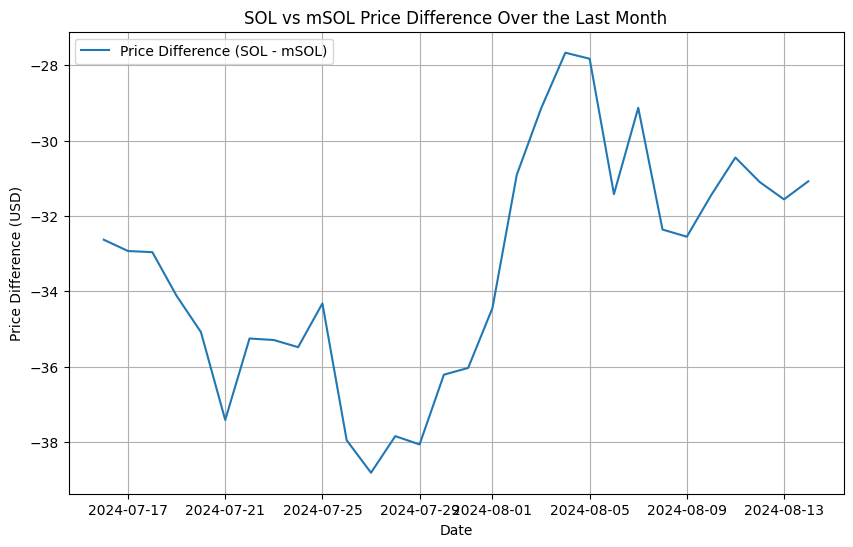

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define the API endpoint and your API key
BASE_URL = "https://api.exchange.coinbase.com"
headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "CB-ACCESS-KEY": "YOUR_API_KEY"  # Replace with your actual Coinbase API key
}

# Function to fetch historical data
def fetch_historical_data(product_id, start, end, granularity):
    url = f"{BASE_URL}/products/{product_id}/candles"
    params = {
        "start": start,
        "end": end,
        "granularity": granularity  # 86400 for daily candles
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    return pd.DataFrame(data, columns=["time", "low", "high", "open", "close", "volume"])

# Define the time range (1 month)
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=30)

# Fetch the data for SOL-USD and MSOL-USD
sol_data = fetch_historical_data("SOL-USD", start_date.isoformat(), end_date.isoformat(), 86400)
msol_data = fetch_historical_data("MSOL-USD", start_date.isoformat(), end_date.isoformat(), 86400)

# Convert the 'time' column to datetime
sol_data['time'] = pd.to_datetime(sol_data['time'], unit='s')
msol_data['time'] = pd.to_datetime(msol_data['time'], unit='s')

# Calculate the difference in closing prices
data = pd.merge(sol_data[['time', 'close']], msol_data[['time', 'close']], on='time', suffixes=('_sol', '_msol'))
data['price_difference'] = data['close_sol'] - data['close_msol']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['price_difference'], label='Price Difference (SOL - mSOL)')
plt.title('SOL vs mSOL Price Difference Over the Last Month')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')
plt.legend()
plt.grid(True)
plt.show()



c:\Users\ayode\OneDrive - Imperial College London\Portfolio\.conda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ayode\OneDrive - Imperial College London\Portfolio\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ayode\OneDrive - Imperial College London\Portfolio\.conda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ayode\OneDrive - Imperial College London\Portfolio\.conda\Lib\site-packages\statsmodels\tsa\st

TypeError: object of type 'int' has no len()

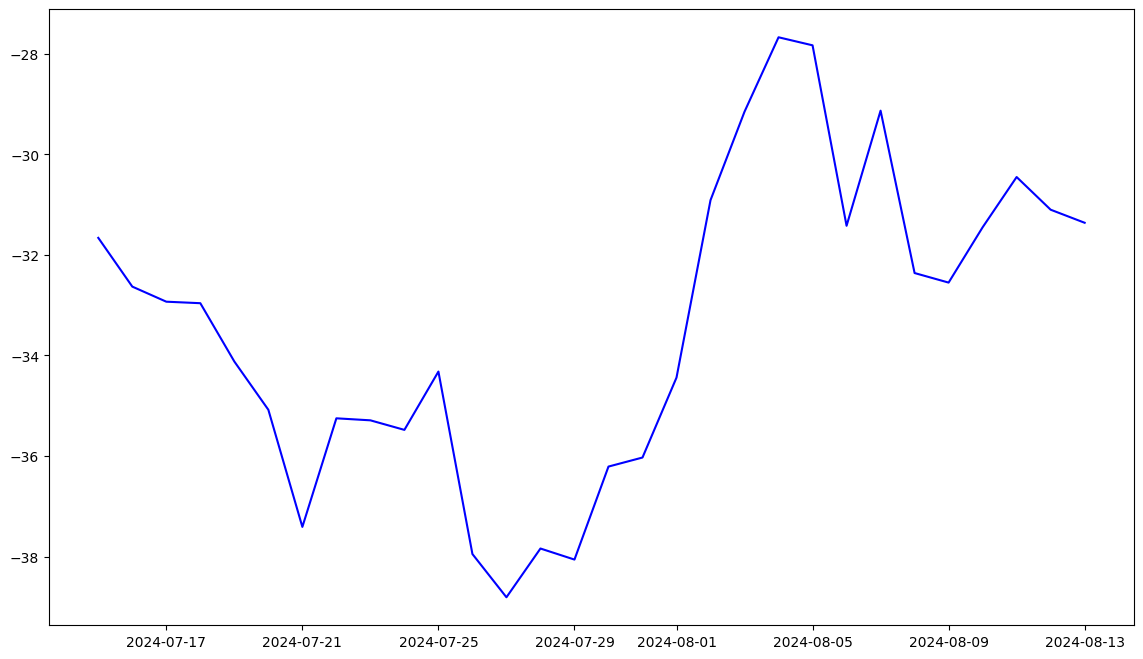

In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
from datetime import datetime, timedelta

# Coinbase API endpoint
BASE_URL = "https://api.exchange.coinbase.com"

# Function to fetch historical data from Coinbase API
def fetch_historical_data(product_id, start, end, granularity):
    url = f"{BASE_URL}/products/{product_id}/candles"
    params = {
        "start": start,
        "end": end,
        "granularity": granularity  # 86400 for daily candles
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data, columns=["time", "low", "high", "open", "close", "volume"])

# Define the time range (1 month)
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=30)

# Fetch the data for SOL-USD and MSOL-USD
sol_data = fetch_historical_data("SOL-USD", start_date.isoformat(), end_date.isoformat(), 86400)
msol_data = fetch_historical_data("MSOL-USD", start_date.isoformat(), end_date.isoformat(), 86400)

# Convert the 'time' column to datetime
sol_data['time'] = pd.to_datetime(sol_data['time'], unit='s')
msol_data['time'] = pd.to_datetime(msol_data['time'], unit='s')

# Merge the two dataframes on the time column
data = pd.merge(sol_data[['time', 'close']], msol_data[['time', 'close']], on='time', suffixes=('_sol', '_msol'))

# Calculate the difference in closing prices
data['price_difference'] = data['close_sol'] - data['close_msol']

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Store results for plotting
train_sizes = []
test_errors = []
forecasted_values = []
actual_values = []

# Time series cross-validation loop
for train_index, test_index in tscv.split(data['price_difference']):
    train, test = data['price_difference'].iloc[train_index], data['price_difference'].iloc[test_index]
    
    # Fit ARIMA model
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast for the test set
    forecast = model_fit.forecast(steps=len(test))
    
    # Calculate RMSE for this fold
    error = np.sqrt(mean_squared_error(test, forecast))
    test_errors.append(error)
    
    # Store the size of training data used
    train_sizes.append(len(train))
    
    # Store the forecast and actual values for plotting
    forecasted_values.extend(forecast)
    actual_values.extend(test)

# Train the final ARIMA model on the entire dataset
final_model = ARIMA(data['price_difference'], order=(5, 1, 0))
final_model_fit = final_model.fit()

# Forecast the next 30 days
future_forecast = final_model_fit.forecast(steps=30)
 
# Create a time index for future forecast
future_dates = pd.date_range(start=data['time'].iloc[-1] + timedelta(days=1), periods=30, freq='D')

# Plot the results
plt.figure(figsize=(14, 8))

# Plot historical differences
plt.plot(data['time'], data['price_difference'], label='Historical Price Difference', color='blue')

# Plot forecasted values from cross-validation
plt.plot(data['time'][len(train_sizes[0]):], forecasted_values, label='Validation Predictions', color='orange')

# Plot future forecast
plt.plot(future_dates, future_forecast, label='Future Forecast', color='green', linestyle='--')

plt.title('SOL vs mSOL Price Difference with ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Print average RMSE
print(f'Average RMSE over {tscv.n_splits} folds: {np.mean(test_errors)}')

In [ ]:
#project aim to compare tokens to wrapped tokens, find a delta, compare variety of tokens, and predict future deltas of tokens

#
